# fmdtools-AdaStress integration


**NOTE: This notebook may not run correctly, see ticket RAD-224**

This goal of this notebook is to illustrate running [Adaptive Stress Testing](https://www.nasa.gov/content/tech/rse/research/adastress) on fmdtools model using the AdaStress package.

For this setup to work, first install:
- AdaStress (and related packages) in Julia
- fmdtools (and related packages) in Python
- PyCall in Julia
- - Make sure ENV["PYTHON"] points to python kernel where fmdtools is installed 
- PyJulia in Python

In [1]:
# Commands for building PyCall where python is located:
# ENV["PYTHON"] = "C:\\Users\\dhulse\\AppData\\Local\\anaconda3\\python.exe"
# using Pkg
# Pkg.build("PyCall")

In [2]:
using Plots
using AdaStress

### Python setup:

First, we get the fmdtools model from its respective folder

In [3]:

using PyCall
#ENV["MPLBACKEND"]="qt5agg"
using PyPlot
py"""
import sys, os
sys.path.insert(0,os.curdir)
sys.path.insert(1,os.path.join('..'))
"""

In [4]:
PyCall.pyversion

v"3.10.9"

In [5]:
#pygui_start(:qt)
#PyCall.fixqtpath()

Next, we get the module--in this case we will be using the stochastic pump model in `/example_pump/pump_stochastic`

In [6]:
pump_module = pyimport("pump_stochastic")
pump_model = pump_module.Pump(p = Dict("delay" => 1.0))
pump_model.p

PyObject PumpParam(cost=('repair', 'water'), delay=1)

To get the propagation/analysis methods, we can further import the fmdtools packages...

In [7]:
fmd = pyimport("fmdtools")
prop = fmd.sim.propagate
an = fmd.analyze

PyObject <module 'fmdtools.analyze' from 'c:\\users\\dhulse\\documents\\github\\fmdtools\\fmdtools\\analyze\\__init__.py'>

Example simulation

In [8]:
endresult, mdlhist = prop.nominal(pump_model, run_stochastic=true);

NOTE: in order for `Result.plot_line` to work correctly, make sure to use the `Using PyCall` command at the beginning.

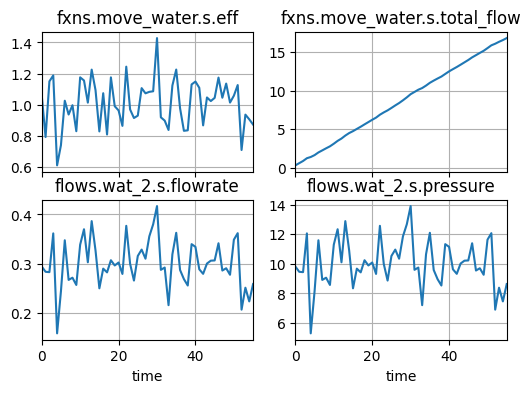

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <Axes: title={'center': 'fxns.move_water.s.eff'}, xlabel=' '>, PyObject <Axes: title={'center': 'fxns.move_water.s.total_flow'}, xlabel=' '>, PyObject <Axes: title={'center': 'flows.wat_2.s.flowrate'}, xlabel='time'>, PyObject <Axes: title={'center': 'flows.wat_2.s.pressure'}, xlabel='time'>])

In [9]:
fig, axs = mdlhist.plot_line("fxns.move_water.s.eff", 
                                 "fxns.move_water.s.total_flow", 
                                 "flows.wat_2.s.flowrate", 
                                 "flows.wat_2.s.pressure")

## AdaStress Setup

Interfacing AdaStress with fmdtools models is enabled by the `DynamicProblem` class in `sim.search` (though this can also be done manually). See below. 

In [10]:
DynamicProblem = fmd.sim.search.DynamicInterface

PyObject <class 'fmdtools.sim.search.DynamicInterface'>

In [11]:
prob = DynamicProblem(pump_model)

PyObject <fmdtools.sim.search.DynamicInterface object at 0x000001FBEA47D7B0>

Defining the simulation is quite simple with the DynamicProblem class. Note the possible options from this class

In [12]:
?DynamicProblem.__init__


        Initialize the problem.

        Parameters
        ----------
        mdl : Model
            Model defining the simulation.
        mdl_kwargs : dict, optional
            Parameters to run the model at. The default is {}.
        t_max : float, optional
            Maximum simulation time. The default is False.
        track : str/dict, optional
            Properties of the model to track over time. The default is "all".
        run_stochastic : bool/str, optional
            Whether to run stochastic behaviors (True/False) and/or
            return pdf ("track_pdf"). The default is "track_pdf".
        desired_result : list, optional
            List of desired results to return at each update. The default is [].
        use_end_condition : bool, optional
            Whether to use model end-condition. The default is None.
        

In [13]:
Base.@kwdef mutable struct PumpSim <: AdaStress.BlackBox
    sim::PyObject = DynamicProblem(pump_model)
end

PumpSim

In [14]:
function initialize!(sim::PumpSim)
    sim.sim = DynamicProblem(pump_model)
end

initialize! (generic function with 1 method)

Updating is further enabled by DynamicProblem.update

In [15]:
?DynamicProblem.update


        Update the model states at the simulation time and iterates time.

        Parameters
        ----------
        seed : seed, optional
            Seed for the simulation. The default is {}.
        faults : dict, optional
            faults to inject in the model, with structure {fxn:[faults]}.
            The default is {}.
        disturbances : dict, optional
            Variables to change in the model, with structure {fxn.var:value}.
            The default is {}.

        Returns
        -------
        returns : dict
            dictionary of returns with values corresponding to desired_result
        

In [16]:
function update!(sim::PumpSim)
    seed = rand(0:1_000_000_000)
    returns = sim.sim.update(seed=seed)
    return log(returns["pdf"]) # note: needs to return a probability from somewhere - needs to be a log pdf?
end

update! (generic function with 1 method)

Model end-states can be interfaced with using `DynamicProblem.check_sim_end`, which additionally accomodates external conditions.

In [17]:
function isterminal!(sim::PumpSim)
    has_faults = sim.sim.mdl.fxns["move_water"].m.any_faults() # our external condition
    terminal = sim.sim.check_sim_end(external_condition=has_faults)
    return terminal
end

isterminal! (generic function with 1 method)

In [18]:
function isevent!(sim::PumpSim)
    faults = sim.sim.mdl.fxns["move_water"].m.any_faults()
    return faults
end

isevent! (generic function with 1 method)

Finally, the below shows the full setup:

In [19]:
AdaStress.reset!(sim::PumpSim) = initialize!(sim)
AdaStress.step!(sim::PumpSim) = update!(sim)
AdaStress.isterminal(sim::PumpSim) = isterminal!(sim)
AdaStress.isevent(sim::PumpSim) = isevent!(sim)     # difficult: get pressure > 15 ten times
# AdaStress.isevent(sim::PumpSim) = 15.0-sim.mdl.flows["Wat_1"].pressure <= 0 # - easy: just get pressure > 15 (once!)
#AdaStress.distance(sim::PumpSim) = 15.0-sim.mdl.flows["Wat_1"].pressure
AdaStress.distance(sim::PumpSim) = float(sum(sim.sim.mdl.h.flows.wat_1.s.pressure.<=15))

### Running AdaStress Methods

Monte Carlo Search

In [69]:
mcs = AdaStress.Solvers.MCS(num_iterations=10_00)

AdaStress.Solvers.MonteCarloSearch.MCS(1000, 10)

In [70]:
mdp = AdaStress.ASTMDP(PumpSim())
mdp.reward.event_bonus = 200.0

200.0

In [71]:
using Random

In [72]:
Random.seed!(0)
sol = mcs(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCSResult(UInt32[0x20a6d935, 0x28bba493, 0xb7b93759, 0xd1a1446c, 0… => 206.991
  MCSResult(UInt32[0x084541d7, 0x84540de9, 0x7cc282fe, 0x8c04197f, 0… => 207.019
  MCSResult(UInt32[0x13ad911b, 0xf09a855d, 0x47101ea7, 0x25d57373, 0… => 208.057
  MCSResult(UInt32[0xef54ffaf, 0x5b752e2b, 0x8940f9fe, 0x87bfa056])   => 208.121
  MCSResult(UInt32[0xa4fdc8b9, 0xbc7ce3e9, 0x1d17d64d, 0xc72e51ab, 0… => 208.256
  MCSResult(UInt32[0xfb1a01a1, 0x45b42a6c, 0xdea6badb, 0x49b2b636, 0… => 209.586
  MCSResult(UInt32[0x10c6c90c, 0xb0192166, 0xd7c40237, 0x6b827ac9, 0… => 210.216
  MCSResult(UInt32[0x1c031724, 0x22bca5ad, 0xec5453ee, 0x38a2c995, 0… => 210.228
  MCSResult(UInt32[0x769c9150, 0x211f39ca, 0x8b28f979, 0xb16ab1f2, 0… => 211.552
  MCSResult(UInt32[0x3ab41a82, 0xcd4d763d, 0x219e185b, 0xca868fbb, 0… => 213.017

In [73]:
i=0
mdlhists = Dict()
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    mdlhists[string("scen", i)] = mdp.sim.sim.hist
    i+=1
end
mdlhists = fmd.analyze.history.History(mdlhists)
mdlhists = mdlhists.flatten()

PyObject scen1.i.finished:              array(56)
scen1.i.on:                    array(56)
scen1.r.probdens:              array(56)
scen1.flows.ee_1.s.current:    array(56)
scen1.flows.ee_1.s.voltage:    array(56)
scen1.flows.sig_1.s.power:     array(56)
scen1.flows.wat_1.s.flowrate:  array(56)
scen1.flows.wat_1.s.pressure:  array(56)
scen1.flows.wat_1.s.area:      array(56)
scen1.flows.wat_1.s.level:     array(56)
scen1.flows.wat_2.s.flowrate:  array(56)
scen1.flows.wat_2.s.pressure:  array(56)
scen1.flows.wat_2.s.area:      array(56)
scen1.flows.wat_2.s.level:     array(56)
scen1.fxns.import_ee.s.effstate: array(56)
scen1.fxns.import_ee.m.faults.no_v: array(56)
scen1.fxns.import_ee.m.faults.inf_v: array(56)
scen1.fxns.import_ee.r.s.effstate: array(56)
scen1.fxns.import_ee.r.s.grid_noise: array(56)
scen1.fxns.import_ee.r.probdens: array(56)
scen1.fxns.import_wa           array(56)
scen1.fxns.import_wa           array(56)
scen1.fxns.import_si           array(56)
scen1.fxns.import_signa

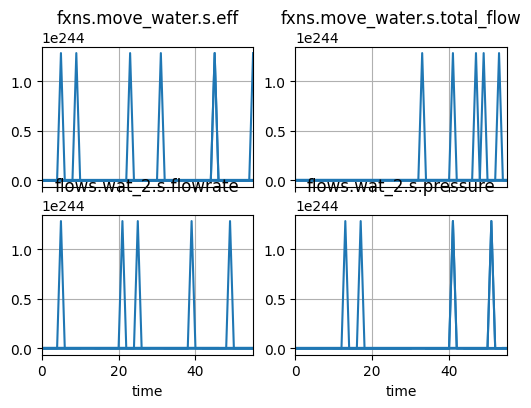

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <Axes: title={'center': 'fxns.move_water.s.eff'}, xlabel=' '>, PyObject <Axes: title={'center': 'fxns.move_water.s.total_flow'}, xlabel=' '>, PyObject <Axes: title={'center': 'flows.wat_2.s.flowrate'}, xlabel='time'>, PyObject <Axes: title={'center': 'flows.wat_2.s.pressure'}, xlabel='time'>])

In [74]:
mdlhists.plot_line("fxns.move_water.s.eff", 
                        "fxns.move_water.s.total_flow", 
                        "flows.wat_2.s.flowrate", 
                        "flows.wat_2.s.pressure")

### MCTS

Monte Carlo Tree Search

In [27]:
mcts = AdaStress.Solvers.MCTS(num_iterations=1000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(1000, 10, 1.0, 0.7, 1.0, nothing)

In [28]:
Random.seed!(0)
@time sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


 14.751713 seconds (5.93 M allocations: 283.844 MiB, 0.48% gc time, 2.24% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCTSResult(UInt32[0x828d83bf, 0x569a8b4b, 0x42db7247, 0x860d2412])  => 203.112
  MCTSResult(UInt32[0x9be7bec6, 0xa281bfa4, 0xa911ec3d])              => 203.12
  MCTSResult(UInt32[0x9be7bec6, 0xd34fd93a, 0x6bc04b0b])              => 203.151
  MCTSResult(UInt32[0xfd5b9189, 0xe6ed8348, 0x53813216])              => 203.248
  MCTSResult(UInt32[0x77d94185, 0x0593823c, 0xe2a9136a, 0x16e247bc, … => 203.706
  MCTSResult(UInt32[0x48cea00e, 0x5e5903be, 0x40184882, 0x11abadd6, … => 204.454
  MCTSResult(UInt32[0xe04f8a60, 0xff8d3670, 0x5846f74e, 0xd2c176d0, … => 204.516
  MCTSResult(UInt32[0x76bdd112, 0x40fc08c9, 0x7151eb1c, 0x25a0e9a5, … => 204.932
  MCTSResult(UInt32[0xc72f45c9, 0x2a4519ab, 0x52413abb])              => 205.292
  MCTSResult(UInt32[0x57387aea, 0xaf5383c3, 0x43d34d08, 0x1720253e, … => 206.777

In [29]:
i=0
mdlhists2 = Dict()
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    mdlhists2[i] = mdp.sim.sim.hist
    i+=1
end
mdlhists2 = fmd.analyze.history.History(mdlhists2)
mdlhists2 = mdlhists2.flatten()

PyObject t0.i.finished:                 array(56)
t0.i.on:                       array(56)
t0.r.probdens:                 array(56)
t0.flows.ee_1.s.current:       array(56)
t0.flows.ee_1.s.voltage:       array(56)
t0.flows.sig_1.s.power:        array(56)
t0.flows.wat_1.s.flowrate:     array(56)
t0.flows.wat_1.s.pressure:     array(56)
t0.flows.wat_1.s.area:         array(56)
t0.flows.wat_1.s.level:        array(56)
t0.flows.wat_2.s.flowrate:     array(56)
t0.flows.wat_2.s.pressure:     array(56)
t0.flows.wat_2.s.area:         array(56)
t0.flows.wat_2.s.level:        array(56)
t0.fxns.import_ee.s.effstate:  array(56)
t0.fxns.import_ee.m.faults.no_v: array(56)
t0.fxns.import_ee.m.faults.inf_v: array(56)
t0.fxns.import_ee.r.s.effstate: array(56)
t0.fxns.import_ee.r.s.grid_noise: array(56)
t0.fxns.import_ee.r.probdens:  array(56)
t0.fxns.import_water.m.faults.no_wat: array(56)
t0.fxns.import_water.m.faults.less_wat: array(56)
t0.fxns.import_signal.m.faults.no_sig: array(56)
t0.fxns.import_

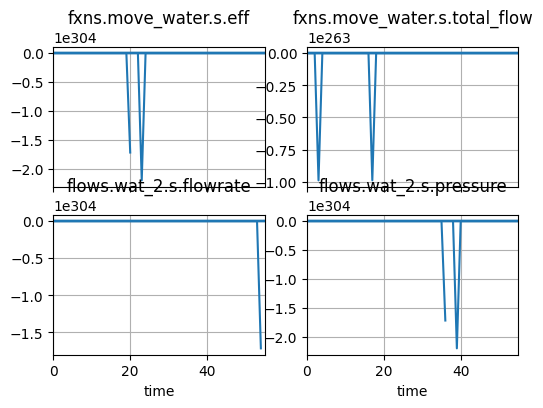

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <Axes: title={'center': 'fxns.move_water.s.eff'}, xlabel=' '>, PyObject <Axes: title={'center': 'fxns.move_water.s.total_flow'}, xlabel=' '>, PyObject <Axes: title={'center': 'flows.wat_2.s.flowrate'}, xlabel='time'>, PyObject <Axes: title={'center': 'flows.wat_2.s.pressure'}, xlabel='time'>])

In [30]:
fig, axs = mdlhists2.plot_line("fxns.move_water.s.eff", "fxns.move_water.s.total_flow",
                    "flows.wat_2.s.flowrate", "flows.wat_2.s.pressure")

As we can see, MCTS finds more breakage faults (8 instead of 3), as a result of being a more informed search method.

## Grey Box Methods

As opposed to black box methods, which share no information about the system state with the agent, grey box methods let the agent sample the random distributions and pass disturbances to the model directly, rather than just passing seeds.

Implementation is based off of: https://github.com/NASA-SW-VnV/AdaStress.jl/blob/master/examples/walk2d/walk2d.ipynb

In [31]:
using AdaStress
import AdaStress.GrayBox
using Distributions
using Random

### Pump

To use the gray box method, we have to first define which variables in the model to sample/update. fmdtools models have two types of random states:
- general random states, which are updated in the behavioral method (whose distributions thus cannot be accessed without looking at the code)
- auto-updating random states, which are updated from a given distribution defined with auto_update=(dist,params). These distributions can be accessed directly from the model.

Both can be queried in AdaStress, but using different methods. In general, however, using a Gray Box method means that *all* stochastic behavior (desired by the analysis) should be represented in AdaStress/Julia, since integration relies on running the model as deterministic.

Below are the random states of the model:

In [32]:
rand_states = pump_model.get_rand_states()

Dict{Any, Any} with 3 entries:
  "move_water"    => Dict{Any, Any}("eff"=>1.0)
  "import_signal" => Dict{Any, Any}("sig_noise"=>1.0)
  "import_ee"     => Dict{Any, Any}("effstate"=>1.0, "grid_noise"=>1.0)

As well as the auto-updating random states:

In [33]:
rand_states = pump_model.get_rand_states(auto_update_only=true)

Dict{Any, Any} with 1 entry:
  "move_water" => Dict{Any, Any}("eff"=>1.0)

### Simulator
The simulator is roughly the same as the simulation for the black box model except it has an `environment` which samples stochastic variables and then changes parameters in the model. Note that in this case `run_stochastic` is set to `false`, since the variables are being sampled in AdaStress itself (rather than the model).

In [34]:
Base.@kwdef mutable struct Simulator <: AdaStress.GrayBox
    sim::PyObject = DynamicProblem(pump_model)
    env::AdaStress.Environment = AdaStress.Environment()
end

function initialize(sim::Simulator)
    sim.env[:eff] = Normal(1.0, 0.2) #creating  
    sim.sim=DynamicProblem(pump_model, run_stochastic=false)
    return
end

function update!(sim::Simulator, value::AdaStress.EnvironmentValue)
    #sim.mdl.set_values("MoveWater.eff", value[:eff])
    disturbances=Dict("move_water.s.eff"=>value[:eff])
    sim.sim.update(disturbances=disturbances)
    return
end

update! (generic function with 2 methods)

The isterminal and isevent functions will be the same as in the black box model.

In [35]:
function isterminal!(sim::Simulator)
    has_faults = sim.sim.mdl.fxns["move_water"].m.any_faults() # our external condition
    terminal = sim.sim.check_sim_end(external_condition=has_faults)
    return terminal
end
function isevent!(sim::Simulator)
    faults = sim.sim.mdl.fxns["move_water"].m.any_faults()
    return faults
end

isevent! (generic function with 2 methods)

The interface to adastress is set up below. Of note is the observation interface, which observes `eff` (which is also the action in this simple setup)

In [36]:
Interface.reset!(sim::Simulator) = initialize(sim)

Interface.environment(sim::Simulator) = sim.env

Interface.observe(sim::Simulator) = vcat(sim.sim.mdl.flows.wat_2.pressure, sim.sim.t / sim.sim.t_max)

Interface.step!(sim::Simulator, value::AdaStress.EnvironmentValue) = update!(sim, value)

Interface.isterminal(sim::Simulator) = isterminal!(sim)

Interface.isevent(sim::Simulator) = isevent!(sim)

Interface.distance(sim::Simulator) = float(sum([(16-max(min(i,16), 0))^2 for i in sim.sim.log["flows.wat_1.s.pressure"]]))

In [37]:
function mdp_env(; kwargs...)
    mdp = Interface.ASTMDP(Simulator(; kwargs...))
    mdp.rewaan.event_bonus = 2000.0
    return mdp
end

mdp_env (generic function with 1 method)

Now using the gray box mdp solver:

In [38]:
# AdaStress.enable("SoftActorCritic")
# using AdaStress.SoftActorCritic

In [39]:
# Random.seed!(0)
# sac = SAC(;
#     obs_dim=2, 
#     act_dim=1,
#     gamma=0.95,
#     act_mins=-1*ones(1),    #number of standard deviations
#     act_maxs=10*ones(1),
#     hidden_sizes=[30,30,30],
#     num_q=2,
#     max_buffer_size=1000000,
#     batch_size=128,
#     epochs=100,
#     update_after=0,
#     update_every=1,
#     steps_per_epoch=54,
#     start_steps=100,
#     max_ep_len=54,
#     num_test_episodes=100,
#     displays=[(:fails, mdp -> mdp.sim.sim.mdl.fxns["MoveWater"].has_fault("mech_break") )],
#     use_gpu=false
# )

# SoftActorCritic.ProgressMeter.ijulia_behavior(:clear)
# ac, info = sac(mdp_env)

In [40]:
# using PyPlot

In [41]:
# plt.plot(info["fails"])

In [42]:
# plt.plot(info["score"])

In [43]:
# ac

In [44]:
# i=0
# mdlhists3 = Dict()
# mdp = mdp_env()
# for i in 1:100
#     a= AdaStress.replay!(mdp, ac)
#     mdlhists3[i] = mdp.sim.sim.hist
#     i+=1
# end
# mdlhists3 = fmd.analyze.history.History(mdlhists3)
# mdlhists3 = mdlhists3.flatten()

In [45]:
# a= AdaStress.replay!(mdp, ac)

In [46]:
# info

In [47]:
# mdlhists3.plot_line("fxns.move_water.s.eff", "fxns.move_water.s.total_flow",
#                     "flows.wat_2.s.flowrate", "flows.wat_2.s.pressure", aggregation="percentile")